In [1]:
#default double_tsek

In [2]:
#export
from collections import defaultdict
import cv2
import gzip
import json
import math
from pathlib import Path
import re
import unicodedata

from deskew import determine_skew
import diff_match_patch as dmp_module
from MTM import matchTemplates, drawBoxesOnRGB
import numpy as np
from openpecha.serializers import Serialize
from tqdm import tqdm
from xml.dom import minidom
import yaml

In [104]:
#exxport
class config:
    # ocr_output paths
    ocr_path = Path('/home/tenzin/ML/project/Esukhia/Google-OCR/archive')
    # peydurma tengyur
#     images_path = ocr_path/'images'/'W1PD95844'
#     res_path = ocr_path/'output'/'W1PD95844'
    # peydurma kangyur
    images_path = ocr_path/'images'/'W1PD96682'
    res_path = ocr_path/'output'/'W1PD96682'
    
    # peydurma path
    peydurma_path = Path('data/peydurma')
    template_path = peydurma_path/'templates'
    peydurma_meta_fn = peydurma_path/'tengyur-peydurma-bdrc.xml'
    
    # dergey opf path
    op_path = Path('/home/tenzin/ML/project/Esukhia/openpecha-user/.openpecha/data/')
    tengyur_opf = op_path/'P000002/P000002.opf'
    kangyur_opf = op_path/'P000001/P000001.opf'
    
    # output_path
    output_path = peydurma_path/'output'
    output_path.mkdir(exist_ok=True)
    output_tmp_path = output_path/'tmp'
    output_tmp_path.mkdir(exist_ok=True)
    
    # annotation
    double_tsek_sym = '$'
    tsek = '་'
    shed = '།'
    
    # image
    img_size = (3969, 2641)
    
    # dev
    debug = False
    
dmp = dmp_module.diff_match_patch()
dmp.Diff_Timeout = 0

In [4]:
import matplotlib.pyplot as plt
import pprint

pp = pprint.PrettyPrinter(indent=4)

def plot(img, cmap=None, sz=(10, 10), axis=False):
    plt.figure(figsize=sz)
    plt.grid(True)
    if not axis:
        plt.axis('off')
        plt.grid(False)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img, cmap=cmap)
    plt.show()

# Create template

In [5]:
# def to_box(coord):
#     x, y, w, h = coord
#     x2, y2 = x+w, y+h
#     return x, y, x2, y2


# def create_template(img_path, coord, t_fn=None, template=False):
#     img = cv2.imread(str(img_path))
#     print(img.shape)
#     if not template:
#         img = cv2.resize(img, (config.img_size[1], config.img_size[0]))
#     img_copy = img.copy()
#     x1, y1, x2, y2 = to_box(coord)
#     cv2.rectangle(img_copy, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
#     x, y, w, h = coord
#     template = img[y:y+h, x:x+w]
#     plot(template)
#     plot(img_copy, sz=(25, 25))

#     if t_fn:
#         cv2.imwrite(str(t_fn), template)

In [6]:
# coord = (2139, 1282, 18, 135) # (x, y, w, h)
# create_template('data/test-mantra.jpg', coord, t_fn=config.template_path/'double_tsek_02.png')

In [7]:
# img_path = config.images_path/'I1PD95846'/'I1PD958460141.jpg'
# coord = (1162, 1910, 13, 135) # (x, y, w, h)
# create_template(img_path, coord, t_fn=config.template_path/'double_tsek_03.png')

# Pure OpenCV2

### detect paragraphs

In [8]:
# #image = cv2.imread('data/test.jpeg')
# image = cv2.imread('data/test_diff_size.jpeg')
# image = imutils.resize(image, height=3969, width=2645)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(gray, (7,7), 0)
# thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# # Create rectangular structuring element and dilate
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
# dilate = cv2.dilate(thresh, kernel, iterations=7)
# plot(dilate, cmap='gray', sz=(25, 25))

# # Find contours and draw rectangle
# cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts = cnts[0] if len(cnts) == 2 else cnts[1]
# for c in cnts:
#     x,y,w,h = cv2.boundingRect(c)
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

# plot(image, sz=(25, 25))

### Text Skew Correction

In [9]:
# def image_deskew2(image, show_diff=False):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray = cv2.bitwise_not(gray)
#     thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
#     coords = np.column_stack(np.where(thresh > 2))
#     angle = cv2.minAreaRect(coords)[-1]

#     if angle < -45:
#         angle = -(90 + angle)
#     else:
#         angle = -angle

#     # rotate the image to deskew it
#     (h, w) = image.shape[:2]
#     center = (w // 2, h // 2)
#     M = cv2.getRotationMatrix2D(center, angle, 1.0)
#     rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#     print(f'[INFO] Image dskewed by {angle:.3} angles')
    
#     if show_diff:
#         plot(image, sz=(15, 15), axis=True)
#         plot(rotated, sz=(15, 15), axis=True)
        
#     return rotated

def image_deskew(image, show_diff=False):
    def rotate(image, angle, background):
        old_width, old_height = image.shape[:2]
        angle_radian = math.radians(angle)
        width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
        height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        rot_mat[1, 2] += (width - old_width) / 2
        rot_mat[0, 2] += (height - old_height) / 2
        return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)
    
    if isinstance(image, (str, Path)):
        image = cv2.imread(str(image))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(gray)
    backgroud = tuple([int(x) for x in image[10][10]])
    rotated = rotate(image, angle, backgroud)
    
    print(f'[INFO] Image dskewed by {angle:.4} angles')
    
    if show_diff:
        plot(image, sz=(15, 15), axis=True)
        plot(rotated, sz=(15, 15), axis=True)
        
    return rotated

In [10]:
# %%time
# _ = image_deskew(cv2.imread('data/peydurma/test-set/white_skewed_01.jpg'), show_diff=True);

In [11]:
# %%time
# _ = image_deskew(cv2.imread('data/peydurma/test-set/white_skewed_dtsek_01.jpg'), show_diff=True);

## Template matching

In [12]:
# def sorted_matches(matches):
#     h_sorted_match = []
#     for x, y in matches:
#         found_group = False
#         if h_sorted_match:
#             for h_list in h_sorted_match:
#                 if abs(y-h_list[0][1]) < 5:
#                     h_list.append((x, y))
#                     found_group = True
#         else:
#             h_sorted_match.append([(x, y)])
#             found_group = True

#         if not found_group:
#             h_sorted_match.append([(x, y)])
        
#     full_sorted_match = []
#     for h_list in h_sorted_match:
#         full_sorted_match.append(sorted(h_list, key=lambda x: x[0]))
        
#     return sum(full_sorted_match, [])
    

# def remove_dup_match(match_locations):
#     cleaned_match = []
#     prev_x, prev_y = 0, 0
#     th = 2
#     for x, y in sorted_matches(zip(match_locations[1], match_locations[0])):
#         if abs(x-prev_x) < 5 and abs(y-prev_y) < 5: continue
#         cleaned_match.append((x, y))
#         prev_x, prev_y = x, y
#     return cleaned_match


# def template_match(img, templates):
#     # create edged image
#     if isinstance(img, str):
#         img = cv2.imread(img)
#     if size:
#         img = imutils.resize(img, height=config.img_size[0], width=config.img_size[1])
#     print('Image size:', img.shape)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     #plot(gray, cmap='gray', sz=(50, 50))
#     edged = cv2.Canny(gray, 100, 600)
#     #plot(edged, cmap='gray', sz=(50, 50))
    
#     output = defaultdict(list)
#     clone = img.copy()
#     for template_ in templates:
#         t_type, template, th, data = template_
        
#         # template matching
#         result = cv2.matchTemplate(edged, template, cv2.TM_CCOEFF)
#         min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
#         max_thresh = max_val * th
#         match_locations = np.where(result>=max_thresh)
#         cleaned_match_locations = remove_dup_match(match_locations)
        
#         # Plot
#         w, h = template.shape[::-1]
#         for (x, y) in cleaned_match_locations:
#             output[t_type].append((x, y))
#             cv2.rectangle(clone, (x, y), (x+w, y+h), [0,0,255], 2)
    
#         print(f'No. {t_type} detected: {len(output[t_type])}')

#     plot(clone, cmap='gray', sz=(25, 25))
#     return output

In [13]:
# templates = [
#     ('rectangle', rect_template, 0.9, {}),
#     #('circle', cir_template, 0.7, {'radius': radius})
# ]

In [14]:
#output = template_match('data/test-mantra.jpg', templates)

# Multi-Template-Matching Library

In [15]:
#export
def get_templates(path):
    templates = []
    for p in Path(path).iterdir():
        if not p.name.endswith('.png'): continue
        templates.append((p.stem, cv2.imread(str(p))))
    return templates

def mtm(image, templates, show=False, th=0.9):
    if isinstance(image, (str, Path)):
        image = cv2.imread(str(image))
    matches = []
    try:
        hits = matchTemplates(templates, image, score_threshold=th, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
        for x, y, w, h in list(hits['BBox']):
            matches.append([x, y, x+w, y+h])
        if show: image = drawBoxesOnRGB(image, hits, boxThickness=5, boxColor=(255,0,0))
    except KeyError as ex:
        if ex.args[0] == 'Score':
            print('\t- double tsek not found !')
            return matches

    print(f'\t- no. of double tsek detected: {len(matches)}')    
    if show:
        plot(image, sz=(15, 15))
    
    return matches

In [16]:
templates = get_templates(config.template_path); len(templates)

2

In [17]:
#test_output = mtm('data/test.jpeg', templates, show=True)

In [18]:
#mtm('data/test-mantra.jpg', templates, show=True)

In [19]:
#mtm('data/test-02.jpeg', templates, show=True)

In [20]:
#mtm('data/test_diff_size.jpeg', templates, show=True)

In [21]:
#mtm('data/test-03.jpg', templates, show=True)

## Test on actual Peydurma Image

In [22]:
#mtm('data/peydurma-05.jpg', templates, show=True)

In [23]:
#mtm('data/peydurma/test-set/yellow_01.jpg', templates, show=True)

In [24]:
#mtm('data/peydurma/test-set/yellow_02.jpg', templates, show=True)

In [25]:
#skewed_output = mtm('data/peydurma/test-set/white_skewed_dtsek_01.jpg', templates, show=True)

In [26]:
# deskewed_img = image_deskew(config.images_path/'I1PD95846'/'I1PD958460141.jpg')
# plot(deskewed_img)
#mtm(config.images_path/'I1PD95846'/'I1PD958460141.jpg', templates, show=True)

	- no. of double tsek detected: 2


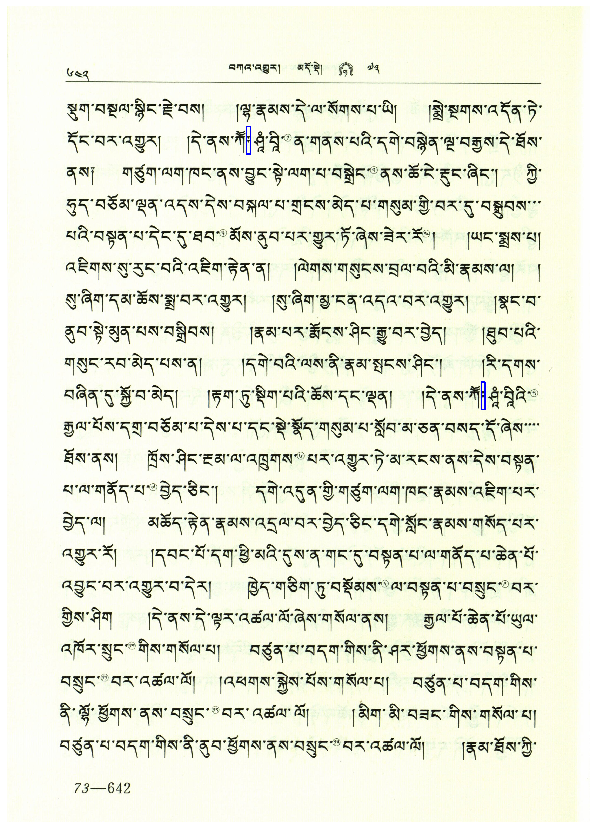

[[2301, 1822, 2318, 1957], [1162, 583, 1180, 718]]

In [27]:
mtm('data/peydurma/test-set/non_breaking.jpg', templates, show=True)

# Find reinsertion span
find line number and char location of double tsek
- input: ocr_boxes, match_loc
- output: line number and char index

In [28]:
# from google.cloud import vision
# from google.cloud.vision import types
# from google.protobuf.json_format import MessageToJson

# vision_client = vision.ImageAnnotatorClient()

In [29]:
# def ocr(image, path):
#     path = Path(path)
#     res_fn = path.parent/f'{path.stem}.json'
#     if res_fn.is_file():
#         response = json.load(res_fn.open())
#     else:
#         if isinstance(image, (str, Path)):
#             with open(path, 'rb') as image_file:
#                 content = image_file.read()
#         else:
#             content = image
#         image = types.Image(content=content)
#         response_pb = vision_client.document_text_detection(image=image)
#         response = eval(MessageToJson(response_pb))
#         json.dump(response, res_fn.open('w'))
#     return response

# convert image array to image bytes
# success, encoded_image = cv2.imencode('.jpg', image)
# image_bytes = encoded_image.tobytes()
# response = ocr(image_bytes, image_path)

### Get OCR output
- unzip ocr output and read the response json
- resize the box w.r.t config.img_size

In [30]:
#export
def get_ocr_output(path):
    imagegroup, img_fn = path.parts[-2:]
    res_fn = config.res_path/imagegroup/f'{img_fn.split(".")[0]}.json.gz'
    return json.load(gzip.open(str(res_fn), 'rb'))

def get_symbol(response):
    for page in response['fullTextAnnotation']['pages']:
        for block in page['blocks']:
            for paragraph in block['paragraphs']:
                for word in paragraph['words']:
                    for symbol in word['symbols']:
                        char = symbol['text']
                        v = symbol['boundingBox']['vertices']
                        box = [v[0]['x'], v[0]['y'], v[2]['x'], v[2]['y']]
                        yield char, box

def get_full_text_annotations(response):
    boxes, text = [], ''
    for char, box in get_symbol(response):
        text += char
        boxes.append(box)
    return boxes, text

def resize_boxes(boxes, old_size):
    "`boxes` are in top-right and bottom-left coord system."
    h, w = old_size[:2]
    h_scale = config.img_size[0]/h
    w_scale = config.img_size[1]/w
    result = []
    for box in boxes:
        # adjust the box
        box[0] *= w_scale
        box[1] *= h_scale
        box[2] *= w_scale
        box[3] *= h_scale
        box = list(map(int, box))
        result.append(box)
    return result

In [31]:
def plot_boxes(img, boxes, show=True, color=[0,0,255]):
    for x1, y1, x2, y2 in boxes[0]:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    if len(boxes) > 1:
        for x1, y1, x2, y2 in boxes[1]:
            cv2.rectangle(img, (x1, y1), (x2, y2), [255,0,0], 5)
    if show: plot(img, sz=(25, 25))
    else: return img

In [32]:
def test_resize_boxes(image_path):
    image = cv2.imread(str(image_path))
    old_size = image.shape
    image = cv2.resize(image, (config.img_size[1], config.img_size[0]))
    response = get_ocr_output(image_path)
    boxes, text = get_full_text_annotations(response)
    print(text)
    boxes = resize_boxes(boxes, old_size)
    plot_boxes(image, [boxes, []])

In [33]:
#test_resize_boxes(config.images_path/'I1PD95846'/'I1PD958460142.jpg')

In [34]:
#test_resize_boxes(config.images_path/'I1PD95846'/'I1PD958460141.jpg')

# Get context of Double Tsek

In [35]:
#export
def cls_box_into_line(boxes, th=20):
    lines = []
    line = []
    prev_y1 = boxes[0][1]
    for box in boxes:
        if abs(box[1] - prev_y1) < th:
            line.append(box)
        else:
            lines.append(line)
            line = []
            line.append(box)
        prev_y1 = box[1]
    else:
        if line: lines.append(line)
    return lines

In [36]:
def test_box_into_line(image_path):
    image = cv2.imread(str(image_path))
    old_size = image.shape
    image = cv2.resize(image, (config.img_size[1], config.img_size[0]))
    response = get_ocr_output(image_path)
    boxes, text = get_full_text_annotations(response)
    boxes = resize_boxes(boxes, old_size)
    boxe_lines = cls_box_into_line(boxes)
    
    for box_line in boxe_lines:
        r, g, b = map(int, np.random.choice(range(256), size=3))
        image = plot_boxes(image, [box_line], show=False, color=(r,g,b))
    plot(image, sz=(25, 25))
    
#test_box_into_line(config.images_path/'I1PD95846'/'I1PD958460048.jpg')

In [37]:
#export
def find_double_tsek_bf(matched_box, boxes, th=20):
    box_lines = cls_box_into_line(boxes)
    pos = 0
    prev_x1 = 0
    for box_line in box_lines:
        if abs(matched_box[1] - box_line[0][1]) < th:
            for i, box in enumerate(box_line):
                if matched_box[0] > prev_x1 and matched_box[0] < box[0]:
                    pos += i-1
                    return pos
        pos += len(box_line)
        

def compute_iou(box_arr1, box_arr2):
    x11, y11, x12, y12 = np.split(box_arr1, 4, axis=1)
    x21, y21, x22, y22 = np.split(box_arr2, 4, axis=1)
    
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    
    return iou


def get_double_tsek_idx(image_path, templates, deskew=False, show_boxes=False):
    # load, deskew and resize the image
    image = cv2.imread(str(image_path))
    old_size = image.shape
    if deskew: image = image_deskew(image)
    image = image = cv2.resize(image, (config.img_size[1], config.img_size[0]))
    
    # find the double tsek boxes
    matches = mtm(image, templates)
    
    # Get ocr boxes
    response = get_ocr_output(image_path)
    boxes, text = get_full_text_annotations(response)
    if not matches: return [], text
    boxes = resize_boxes(boxes, old_size)
    
    # find double tsek char index
    iou_matrix = compute_iou(np.array(matches), np.array(boxes))
    if show_boxes: plot_boxes(image, [boxes, matches])
    idxs = list(np.argmax(iou_matrix, axis=1))
    if 0 in idxs:
        undetected_box_idx = idxs.index(0)
        undetected_box_char_idx = find_double_tsek_bf(matches[undetected_box_idx], boxes)
        idxs[undetected_box_idx] = undetected_box_char_idx
    idxs.sort()
    return idxs, text

In [38]:
def test_get_double_tsek_idx(image_path):
    idxs, text = get_double_tsek_idx(image_path, templates, show_boxes=True)
    print(idxs)
    for cc in idxs:
        print(text[cc-10:cc], text[cc], text[cc+1: cc+10])

In [39]:
#test_get_double_tsek_idx(config.images_path/'I1PD95846'/'I1PD958460047.jpg')

In [40]:
#test_get_double_tsek_idx(config.images_path/'I1PD95846'/'I1PD958460043.jpg')

In [41]:
#test_get_double_tsek_idx(config.images_path/'I1PD95846'/'I1PD958460048.jpg')

In [42]:
def put_whitespaces(text):
    result = ''
    for chunk in text.split('།'):
        if chunk:
            result += chunk + '། '
        else:
            result += '།'
    return result

In [43]:
# test_str = '།ལས་བརྒྱ་ཐམ་པ་པ།༄༅།།རྒྱ་གར་སྐད་དུ།ཀརྨ་ཤ་ཏ་ཀ།བོད་སྐད་དུ།ལས་བརྒྱ་ཐམ་པ་པོ།བམ་པོ་དང་པོ།ཐམས་ཅད་མཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ།།གང་ལས་འཇིག་རྟེན་བླ་མ་བདེ་གཤེགས་ཐོས་པའི་སྒོ་ནས་རབ་སྙན་བརྟན་པའི་གསུང་་་་ལྡན་གྱིས།།སེམས་ཅན་རྣམས་ལ་ཕན་པ་འབའ་ཞིག་བཞེད་ཕྱིར་བཤད་པ་རྣམ་པ་སྣ་ཚོགས་རང་ཉིད་ཀྱིས།།ལོག་པར་ལྟ་བའི་མུན་ནག་ཆེན་པོ་ཐིབས་པོར་$འཐོམས་ཤིངའཁྲུགས་པ་རྣམས་ལ་རབ་གསུངས་པ།།་$དེ་ཡི་མིང་ནི་ལས་རྣམ་བརྒྱ་པ་ཞེས་བྱ་ཡོངས་སུ་ཚང་བ་བདག་གིས་བཤད་ཀྱིས་ཉོན།།སྤྱི་སྡོམ་ནི༑ཁྱི་མོ་དང་ནི་ཤིང་རྟ་དང་།།ཀ་ཙང་ཀ་ལ་བྱམས་མི་སྡུག།བྱ་དང་འཕྱེ་བོ་གང་པོ་དང་།།བུ་རྣམས་དང་ནི་བརྒྱ་བྱིན་ནོ།།སྡོམ་ནི།ཁྱི་མོ་མིག་ཆུང་ལ་རྫོགས་བྱེད་དང་།།སྒྱུར་གཉིས་འཆར་ཀ་རྒྱལ་མཚན་དང༌།།བདེ་བྱེད་མ་དང་ནོར་བུའི་འོད།།སྣ་མའི་མེ་ཏོག་ང་བྱིན་དང༌།།འདུས་མོ་དང་ནི་ཚེམ་བུ་མདོ་སྡེ།ཧ་མཁན༑།ཁྱི་མོ་ཞེས་བྱ་བ་ནི།གླེང་$གཞི་མཉན་དུ་ཡོད་པ་ན་བཞུགས་ཏེ།དེའི་ཚེ་མཉན་དུ་ཡོད་པ་ནི།ཁྱིམ་བདག་ཕྱུག་ཅིང་ནོར་མང་ལ་ལོངས་སྤྱོད་ཆེ་བ་ཡོངས་ས'
# put_whitespaces(test_str)

In [110]:
#export
def rm_running_head(text):
    r_head_end_idx = text.find('༡')
    if r_head_end_idx >= 0  and r_head_end_idx < 500:
        return text[r_head_end_idx+1:]
    else:
        return text[text.find('།')+1:]

def rm_noise(text):
    'remove numbers and etc'
    text = re.sub(f'\d+', '', text)
    for r in ['=', '|', '“', '”', ']', '）', ')', '》', '>', '©', '–', '-', '༸', ('་ི', '་')]:
        if isinstance(r, tuple):
            text = text.replace(r[0], r[1])
        else:
            text = text.replace(r, '')
    return text

def postprocess(text):
    text = rm_running_head(text)
    text = rm_noise(text)
    for f, t in [('$་','་$'), ('$།', '།$'), ('།་$', '།$')]:
        text = text.replace(f, t)
    text = put_whitespaces(text)
    return text

def str_insert(text, idx, char):
    text = text[:idx] + char + text[idx:]
    return text

def add_double_tsek(text, idxs):
    for i, idx in enumerate(idxs):
        text = str_insert(text, idx+i, config.double_tsek_sym)
    return text

def get_double_tsek_text(text_id, path, start, end, engine):
    ann_text_fn = config.output_tmp_path/f'{text_id}-peydurma-ann_text.txt'
    if ann_text_fn.is_file():
        ann_text = ann_text_fn.read_text()
        if engine == 'diff':
            return '', ann_text
        base_text = ann_text.replace(config.double_tsek_sym, '')
        return base_text, ann_text
    ann_text = ''
    for i, path in enumerate(sorted((path).iterdir()), 1):
        if i <  start: continue
        if i > end: break
        print(f'[INFO] {i+1} - Processing {path.name} ...')
        idxs, text = get_double_tsek_idx(path, templates)
        ann_text += f'\n\n{path.name}' if config.debug else ""
        ann_text += postprocess(add_double_tsek(text, idxs))
    ann_text_fn.write_text(ann_text)
    return base_text, ann_text

In [45]:
# config.debug = True
# base_text, ann_text = get_double_tsek_text('T340', config.images_path/'I1PD95846', 0, 0)
# print(ann_text)

# Transfer Annotations

Steps:
1. Paser peydurm-tengyur text index
1. Map peydurma-tengyur text-id to dergey-tengyur text-id
1. Extract corresponding dergey-tengyur text
1. Extract double-tsek from peyduma-tengyur text
1. Create dmp patch of double tsek
1. Apply the dmp patch to dergey-tengyur
1. Parse the dobule-tsek from dergey-tengyur

### 1. Parser peydurma tengyur text index

In [46]:
#export
def get_text_span(node):
    vol, span = '', []
    for loc in node.getElementsByTagName('outline:location'):
        vol = int(loc.attributes['vol'].value)
        span.append(int(loc.attributes['page'].value))
    if not vol:
        return
    return {vol: {'start': min(span), 'end': max(span)}}

def clean_text_id(text_id):
    cats = '  abcd'
    text_id = text_id.strip()
    if text_id == '00':
        return
    elif '-' in text_id:
        id_, cat = text_id.split('-')
        if len(cat) > 1: return
        return f'{id_}{cats[int(cat.strip())]}'
    elif ';' in text_id:
        return text_id.split(';')[0].strip()
    else:
        return text_id      

def get_toh(fn):
    maps = defaultdict(list)
    dom = minidom.parse(str(fn))
    for node in dom.getElementsByTagName('outline:node'):
        if node.attributes['type'].value != "text": continue
        for desc_node in node.getElementsByTagName('outline:description'):
            attrs = desc_node.attributes
            if 'type' in attrs and attrs['type'].value == "toh":
                desc_childnodes = desc_node.childNodes
                if not desc_childnodes: break
                text_id = clean_text_id(desc_childnodes[0].data)
                if not text_id: break
                maps[text_id].append(get_text_span(node))
                break
    return maps

In [47]:
#export
# toh = get_toh(config.peydurma_meta_fn)

### 2. Map peydurma toh to dergey text_id

In [48]:
#export
def map_text_id(text_id, is_kangyur=False):
    if is_kangyur:
        return f'T{text_id}'
    else:
        return f'D{text_id}'

### 2. Extract corresponding dergey-tengyur text

In [49]:
#export
def get_index_layer(path):
    index_layer = yaml.safe_load((path/'index.yml').open())
    return index_layer

In [50]:
# index_layer = get_index_layer(config.tengyur_opf)

In [51]:
#export
def get_base_text(text_id, opf_path, index_layer):
    serializer = Serialize(opf_path, text_id=text_id, index_layer=index_layer)
    #base_text = ''.join(serializer.get_text_base_layer().values())
    base_text = list(serializer.get_text_base_layer().values())[0]
    return base_text

In [52]:
# base_text = get_base_text('D1109', config.tengyur_opf, index_layer)
# base_text[:2000]

### 4. Extract double-tsek from peyduma-tengyur text

In [53]:
# config.debug = False
# peydurma_base_text, peydurma_ann_text = get_double_tsek_text(config.images_path/'I1PD95846')

In [54]:
# print(peydurma_ann_text)

### 5.1 Transfer annotation with patchs 

In [193]:
#except
def transfer_anns_with_patch(base_text, src_text, dest_text):
    "Apply patches computed from `src_text` to `dest_text` on `base_text"
    diffs = dmp.diff_main(src_text, dest_text)
    patches = dmp.patch_make(src_text, diffs)
    ann_text = dmp.patch_apply(patches, base_text)[0]
    double_tsek_idxs = parse_double_tsek(ann_text)
    print(f'\t- Transferred {len(double_tsek_idxs)} out of {len(patches)}')
    return double_tsek_idxs, ann_text

### 5.2 Transfer annotations with diffs

In [194]:
#except
def isNSM(char):
    # Detects nonspacing mark characters
    if unicodedata.category(char) == "Mn":
        return True
    return False

In [57]:
char = 'ཽ'
isNSM(char)

True

In [195]:
#except
def get_first_char_idx(text, char):
    """Return first char idx in `text` and -1 of not found
    
    found har idx is expanded for whitespces after the char.
    """
    is_char_found = False
    idx = -1
    for i in range(len(text)):
        if not is_char_found and text[i] == char:
            is_char_found = True
            idx = i
        elif is_char_found:
            if text[i] != ' ': return i-1
            elif i == len(text)-1: return i
    return idx

In [155]:
string = '01|  567 9'
idx = get_first_char_idx(string, '|')
print(repr(string[:idx+1]), repr(string[idx+1]))

string = '01|  '
idx = get_first_char_idx(string, '|')
print(repr(string[:idx+1]))

'01|  ' '5'
'01|  '


In [196]:
#except
def adjust_next_diff(i, diffs, ann_text, to_char):
    diff_mode, diff_chunk = diffs[i+1]
    # add chars till next tsek to the ann_text
    first_char_idx = get_first_char_idx(diff_chunk, to_char)
    ann_text += diff_chunk[:first_char_idx+1]
    # remove chars till next tsek from diff[i+1]
    diffs[i+1] = (diff_mode, diff_chunk[first_char_idx+1:])
    return ann_text
    

def transfer_anns_with_diff(base_text, dest_text):
    ann_text = ''
    diffs = dmp.diff_main(dest_text, base_text, checklines=False)
    for i in range(len(diffs)):
        if diffs[i][0] == -1:
            if config.double_tsek_sym in diffs[i][1]:
                # check for next diff adjustment
                if i < len(diffs)-1:
                    # adjust next diff[i+1] if it's first char is NSM
                    if isNSM(diffs[i+1][1][0]):
                        ann_text = adjust_next_diff(i, diffs, ann_text, config.tsek)
                
                    # adjust next diff[i+1] if it's first char in tsek
                    elif diffs[i+1][1][0] == config.tsek:
                        ann_text = adjust_next_diff(i, diffs, ann_text, config.tsek)
                        
                    # adjust next diff[i+1] if it's first char in shed
                    elif diffs[i+1][1][0] == config.shed:
                        ann_text = adjust_next_diff(i, diffs, ann_text, config.shed)
                    
                    # adjust next diff[i+1] if its first char is line return
                    elif diffs[i+1][1][0] == '\n':
                        ann_text = adjust_next_diff(i, diffs, ann_text, '\n')

                if len(diffs[i][1]) == 1:
                    ann_text += diffs[i][1]
                else:
                    ann_text += '#'
        else:
            ann_text += diffs[i][1]
    double_tsek_idxs = parse_double_tsek(ann_text)
    print(f'\t- Transferred {len(double_tsek_idxs)} out of {dest_text.count(config.double_tsek_sym)}')
    return double_tsek_idxs, ann_text

In [188]:
# NSM case
p_text = 'དེ་ནས་ཀོ$ཧཱུཾ་བཱི་ན་'
d_text = 'དེ་ནས་ཀཽ་ཤཱཾ་བཱི་ན་གནས་'
transfer_anns_with_diff(d_text, p_text)

	- Transferred 1 out of 1


([9], 'དེ་ནས་ཀཽ་$ཤཱཾ་བཱི་ན་གནས་')

In [189]:
# adjust marker which is diffed before tsek
p_text = 'རིག་པས$༔མ་རིག་པའི་སྒོ་'
d_text = 'རིག་པས་མ་རིག་པའི་སྒོ་'
transfer_anns_with_diff(d_text, p_text)

	- Transferred 1 out of 1


([7], 'རིག་པས་$མ་རིག་པའི་སྒོ་')

In [190]:
p_text = 'ནི༑$ལྷ་སྦྱིན་འདི་ཉིད་'
d_text = '་ནི། ལྷ་སྦྱིན་འདི་ཉིད་'
transfer_anns_with_diff(d_text, p_text)

	- Transferred 1 out of 1


([5], '་ནི། $ལྷ་སྦྱིན་འདི་ཉིད་')

In [191]:
p_text = 'ཟད་དེ། $ད་ནི་དེ་'
d_text = 'ཟད་དེ།\nད་ནི་དེ་'
transfer_anns_with_diff(d_text, p_text)

	- Transferred 1 out of 1


([7], 'ཟད་དེ།\n$ད་ནི་དེ་')

### 7. Parse the double-tsek from dergey-tengyur

In [197]:
#except
def parse_double_tsek(text):
    double_tsek_idxs = []
    base_char_idx = 0
    for c in text:
        if c == config.double_tsek_sym:
            double_tsek_idxs.append(base_char_idx)
            continue
        base_char_idx += 1
    return double_tsek_idxs

In [167]:
# pedurma_ann_text = 'ལས་བརྒྱ་ཐམ་པ་པ། ༄༅། །རྒྱ་གར་སྐད་དུ། ཀརྨ་ཤ་ཏ་ཀ། བོད་སྐད་དུ། ལས་བརྒྱ་ཐམ་པ་པོ། བམ་པོ་དང་པོ། ཐམས་ཅད་མཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ། །གང་ལས་འཇིག་རྟེན་བླ་མ་བདེ་གཤེགས་ཐོས་པའི་སྒོ་ནས་རབ་སྙན་བརྟན་པའི་གསུང་་་་ལྡན་གྱིས། །སེམས་ཅན་རྣམས་ལ་ཕན་པ་འབའ་ཞིག་བཞེད་ཕྱིར་བཤད་པ་རྣམ་པ་སྣ་ཚོགས་རང་ཉིད་ཀྱིས། །ལོག་པར་ལྟ་བའི་མུན་ནག་ཆེན་པོ་ཐིབས་པོར་$འཐོམས་ཤིངའཁྲུགས་པ་རྣམས་ལ་རབ་གསུངས་པ། །$དེ་ཡི་མིང་ནི་ལས་རྣམ་བརྒྱ་པ་ཞེས་བྱ་ཡོངས་སུ་ཚང་བ་བདག་གིས་བཤད་ཀྱིས་ཉོན། །སྤྱི་སྡོམ་ནི༑ཁྱི་མོ་དང་ནི་ཤིང་རྟ་དང་། །ཀ་ཙང་ཀ་ལ་བྱམས་མི་སྡུག། བྱ་དང་འཕྱེ་བོ་གང་པོ་དང་། །བུ་རྣམས་དང་ནི་བརྒྱ་བྱིན་ནོ། །སྡོམ་ནི།'
# derge_text = '༄༅༅། །རྒྱ་གར་སྐད་དུ། ཀརྨ་ཤ་ཏ་ཀ། བོད་སྐད་དུ། ལས་བརྒྱ་ཐམ་པ་པ། བམ་པོ་དང་པོ། ཐམས་ཅད་མཁྱེན་པ་ལ་ཕྱག་འཚལ་ལོ། །གང་ལས་འཇིག་རྟེན་བླ་མ་བདེ་གཤེགས་ཐོས་པའི་སྒོ་ནས་རབ་སྙན་བརྟན་པའི་གསུང་ལྡན་གྱིས། །སེམས་ཅན་རྣམས་ལ་ཕན་པ་འབའ་ཞིག་བཞེད་ཕྱིར་བཤད་པ་རྣམ་པ་སྣ་ཚོགས་རང་ཉིད་ཀྱིས། །ལོག་པར་ལྟ་བའི་མུན་ནག་ཆེན་པོ་ཐིབས་པོར་འཐོམས་ཤིང་འཁྲུགས་པ་རྣམས་ལ་རབ་གསུངས་པ། །དེ་ཡི་མིང་ནི་ལས་རྣམ་བརྒྱ་པ་ཞེས་བྱ་ཡོངས་སུ་ཚང་བ་བདག་གིས་བཤད་ཀྱིས་ཉོན། །སྤྱི་སྡོམ་ནི། ཁྱི་མོ་དང་ནི་ཤིང་རྟ་དང་། །ཀ་ཙང་ཀ་ལ་བྱམས་མི་སྡུག །བྱ་དང་འཕྱེ་བོ་གང་པོ་དང་། །བུ་རྣམས་དང་ནི་བརྒྱ་བྱིན་ནོ། །སྡོམ་ནི། ཁྱི་མོ་མིག་ཆུང་'
# transfer_anns_with_diff(derge_text, pedurma_ann_text)

## RUN

In [198]:
#except
def run(text_id, p_vol_path, opf_path, index_layer, start=1, end=float('inf'), replace=False, engine='diff'):
    print(f'[INFO] Transferring double tsek for {text_id}')
    out_idxs_fn = config.output_path/f'{text_id}-dtsek_idxs.txt'
    ann_text_fn = config.output_path/f'{text_id}-ann_text.txt'
    if not out_idxs_fn.is_file() or replace:
        base_text = get_base_text(text_id, opf_path, index_layer)
        p_base_text, p_ann_text = get_double_tsek_text(text_id, p_vol_path, start, end, engine)
        if engine == 'diff':
            double_tsek_idxs, ann_text = transfer_anns_with_diff(base_text, p_ann_text)
        elif engine == 'patch':
            double_tsek_idxs, ann_text = transfer_anns_with_patch(base_text, p_base_text, p_ann_text)

        out_idxs_fn.write_text('\n'.join(map(str, double_tsek_idxs)))
        ann_text_fn.write_text(ann_text)
    print(f'[INFO] Double tsek indices are save at {config.output_path}')

In [77]:
index_layer = get_index_layer(config.kangyur_opf)

In [169]:
run('T340',
    config.images_path/'I1PD96856',
    config.kangyur_opf,
    index_layer,
    start=19,
    end=749,
    replace=True
)

[INFO] Transferring double tsek for T340
	- Transferred 1393 out of 1473
[INFO] Double tsek indices are save at data/peydurma/output


In [8]:
ann_text = (config.output_path/f'T340-ann_text.txt').read_text()
out_idxs_fn = config.output_path/f'T340-dtsek_idxs.txt'
dts = parse_double_tsek(ann_text); print(len(dts))
out_idxs_fn.write_text('\n'.join(map(str, dts)))

1472


10094

### Text Similarity

In [71]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split('་'))
    b = set(str2.split('་'))
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [72]:
str1 = '༄༅༅། །རྒྱ་གར་སྐད་དུ། ཡོ་ག་རཏྣ་མཱ་ལ་ནཱ་མ་ཧེ་བཛྲ་པཉྩི་ཀཱ། བོད་སྐད་དུ། དགྱེས་པ་རྡོ་རྗེའི་དཀའ་འགྲེལ་རྣལ་འབྱོར་རིན་པོ་ཆེའི་ཕྲེང་བ་ཞེས་བྱ་བ། དཔལ་དགྱེས་པའི་རྡོ་རྗེ་ལ་ཕྱག་'
str2 = '༄༅༅། །རྒྱ་གར་སྐད་དུ། ཡོ་ག་རཏྣ་མཱ་ལ་ནཱ་མ་ཧེ་པཉྩི་ཀཱ། བོད་སྐད་དུ། དགྱེས་པ་རྡོ་རྗེའི་དཀའ་རྣལ་འབྱོར་རིན་ངག་གི་དབང་ཕྱུག་པོ་ཆེའི་ཕྲེང་བ་ཞེས་བྱ་བ། དཔལ་དགྱེས་པའི་རྡོ་རྗེ་ལ་ཕྱག་'

In [73]:
str3 = '༄༅༅། །རྒྱ་གར་སྐད་དུ། ཧེ་བཛྲ་ཏནྟྲ་པཉྫི་ཀཱ་པདྨ་ནི་ནཱ་མ། བོད་སྐད་དུ། ཀྱེའི་རྡོ་རྗེའི་རྒྱུད་ཀྱི་དཀའ་འགྲེལ་པདྨ་ཅན་ཞེས་བྱ་བ། ངག་གི་དབང་ཕྱུག་འཇམ་དཔལ་གཞོན་ནུར་གྱུར་པ་ལ་ཕྱག་འཚལ་ལོ།'

In [ ]:
get_jaccard_sim(str1, str2)

In [ ]:
get_jaccard_sim(str1, str3)